<a href="https://colab.research.google.com/github/PrathyushaRagavAdari/Dynamic-Auth-Agent/blob/main/Week_3_Hands_On_Multimodal_RAG_Product_Sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prathyu Adari
16371669
pradfy

In [6]:
# ==========================================
# STEP 1: INSTALL DEPENDENCIES
# ==========================================
!apt-get install poppler-utils tesseract-ocr
# Force upgrade langchain and install pymupdf for faster PDF loading
!pip install -U langchain langchain-huggingface langchain-community faiss-cpu rank_bm25 unstructured[all-docs] pytesseract pypdf pymupdf huggingface_hub

import os
import torch
from google.colab import userdata

# ==========================================
# STEP 2: AUTHENTICATION
# ==========================================
try:
    hf_token = userdata.get('HF_Token')
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token
    print("✅ Successfully retrieved HF_Token from Secrets.")
except Exception as e:
    print("❌ Secrets Error: Could not find 'HF_Token'.")
    import getpass
    if "HUGGINGFACEHUB_API_TOKEN" not in os.environ:
        os.environ["HUGGINGFACEHUB_API_TOKEN"] = getpass.getpass("Enter Hugging Face Token manually: ")

# ==========================================
# STEP 3: IMPORTS
# ==========================================
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from transformers import pipeline
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document

# Robust Import for EnsembleRetriever with Fallback
EnsembleRetriever = None
try:
    from langchain.retrievers import EnsembleRetriever
except ImportError:
    try:
        from langchain.retrievers.ensemble import EnsembleRetriever
    except ImportError:
        print("⚠️ WARNING: Could not import EnsembleRetriever. Will fall back to Dense Retriever only.")

# ==========================================
# STEP 4: DATA INGESTION
# ==========================================
print("--- 1. Ingesting Data ---")

pdf_path = "/content/data/nist_guidelines.pdf"
if not os.path.exists(pdf_path):
    print(f"File not found at {pdf_path}. Downloading NIST SP 800-63B...")
    os.makedirs(os.path.dirname(pdf_path), exist_ok=True)
    !wget -q -O {pdf_path} https://nvlpubs.nist.gov/nistpubs/SpecialPublications/NIST.SP.800-63b.pdf
    print("Download complete.")

# Use PyMuPDFLoader for faster parsing
loader = PyMuPDFLoader(pdf_path)
docs = loader.load()

# Simulated Image Caption
manual_image_caption = """
[IMAGE CONTEXT: Table 5-1 Authenticator Assurance Level (AAL) Requirements]
- AAL1: Requires single-factor authentication. Provides some assurance that the claimant controls an authenticator.
- AAL2: Requires two distinct authentication factors (e.g., Password + OTP). Provides high confidence.
- AAL3: Requires a hardware-based authenticator and cryptographic resistance to verifier impersonation. Provides very high confidence.
"""
image_doc = Document(page_content=manual_image_caption, metadata={"source": "aal_table.png", "type": "image_caption"})
docs.append(image_doc)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splits = text_splitter.split_documents(docs)
print(f"✅ Data split into {len(splits)} chunks.")

# ==========================================
# STEP 5: HYBRID RETRIEVAL
# ==========================================
print("--- 2. Building Hybrid Index ---")

# A. Dense Retriever
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(splits, embeddings)
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# B. Sparse Retriever
sparse_retriever = BM25Retriever.from_documents(splits)
sparse_retriever.k = 5

# C. Hybrid Fusion (with graceful fallback)
if EnsembleRetriever:
    ensemble_retriever = EnsembleRetriever(
        retrievers=[dense_retriever, sparse_retriever],
        weights=[0.6, 0.4]
    )
    print("✅ Using EnsembleRetriever (Dense + Sparse)")
else:
    ensemble_retriever = dense_retriever
    print("⚠️ EnsembleRetriever missing. Using Dense Retriever only.")

# ==========================================
# STEP 6: RAG CHAIN
# ==========================================
print("--- 3. Initializing Flan-T5-Large (Local) ---")

# Run locally to avoid API provider issues
# Check for GPU availability
device = 0 if torch.cuda.is_available() else -1
print(f"✅ Loading model on device: {'GPU' if device == 0 else 'CPU'}")

pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    max_new_tokens=512,
    model_kwargs={"temperature": 0.1},
    device=device
)

llm = HuggingFacePipeline(pipeline=pipe)

template = """You are a Bank Compliance Auditor. Answer the question based ONLY on the context below.
If the answer is not in the context, say "I do not have enough evidence."

CONTEXT:
{context}

QUESTION:
{question}

ANSWER:
"""
prompt = PromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(f"[Source: {d.metadata.get('source', 'Unknown')}]\n{d.page_content}" for d in docs)

rag_chain = (
    {"context": ensemble_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# ==========================================
# STEP 7: EVALUATION
# ==========================================
print("\n=== STARTING EVALUATION SPRINT ===\n")

# TASK 1
q1 = "What are the requirements for AAL3 according to the table?"
print(f"--- TASK 1: Multimodal Query ---\nQ: {q1}")
print(f"A: {rag_chain.invoke(q1)}\n")

# TASK 2
q2 = "What is the definition of a 'credential CSP'?"
print(f"--- TASK 2: Text Query ---\nQ: {q2}")
print(f"A: {rag_chain.invoke(q2)}\n")

# TASK 3
q3 = "How do I make a chocolate cake?"
print(f"--- TASK 3: Refusal Test ---\nQ: {q3}")
print(f"A: {rag_chain.invoke(q3)}\n")

print("\n=== SPRINT COMPLETE ===")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Using cached huggingface_hub-1.4.0-py3-none-any.whl.metadata (13 kB)
✅ Successfully retrieved HF_Token from Secrets.
⚠️ WARNING: Could not import EnsembleRetriever. Will fall back to Dense Retriever only.
--- 1. Ingesting Data ---
✅ Data split into 261 chunks.
--- 2. Building Hybrid Index ---
⚠️ EnsembleRetriever missing. Using Dense Retriever only.
--- 3. Initializing Flan-T5-Large (Local) ---
✅ Loading model on device: GPU


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (1006 > 512). Running this sequence through the model will result in indexing errors



=== STARTING EVALUATION SPRINT ===

--- TASK 1: Multimodal Query ---
Q: What are the requirements for AAL3 according to the table?
A: A hardware-based authenticator and cryptographic resistance to verifier impersonation

--- TASK 2: Text Query ---
Q: What is the definition of a 'credential CSP'?
A: I do not have enough evidence

--- TASK 3: Refusal Test ---
Q: How do I make a chocolate cake?
A: I do not have enough evidence.


=== SPRINT COMPLETE ===


In [8]:
import time
import numpy as np
import pandas as pd

# ==========================================
# STEP 1: DEFINE EVALUATION DATASET (Ground Truth)
# ==========================================
# In a real product, humans label these. For this sprint, we define them manually.
eval_data = [
    {
        "question": "What are the requirements for AAL3?",
        "ground_truth_keywords": ["hardware", "cryptographic", "verifier impersonation"],
        "expected_doc_source": "image_caption"  # We expect this to come from the image
    },
    {
        "question": "What is a credential CSP?",
        "ground_truth_keywords": ["CSP", "credential service provider", "trusted third party"],
        "expected_doc_source": "nist_guidelines.pdf"
    },
    {
        "question": "How do I secure a password?",
        "ground_truth_keywords": ["salt", "hash", "complexity"],
        "expected_doc_source": "nist_guidelines.pdf"
    }
]

# ==========================================
# STEP 2: METRIC CALCULATION FUNCTIONS
# ==========================================

def calculate_retrieval_metrics(question, keywords, k=5):
    """
    Simulates P@K and R@K by checking if keywords appear in retrieved chunks.
    """
    # 1. Retrieve Docs
    docs = ensemble_retriever.invoke(question) # Get top docs (default k is usually 4 or 5)
    retrieved_k = docs[:k]

    # 2. Calculate Precision (How many chunks are relevant?)
    # Heuristic: A chunk is "relevant" if it contains at least one ground truth keyword
    relevant_chunks = 0
    for doc in retrieved_k:
        content = doc.page_content.lower()
        if any(kw.lower() in content for kw in keywords):
            relevant_chunks += 1

    precision_at_k = relevant_chunks / len(retrieved_k) if retrieved_k else 0

    # 3. Calculate Recall (Did we find the answer at all?)
    # Heuristic: Recall is 1.0 if ANY chunk contains the answer, 0.0 otherwise
    recall_at_k = 1.0 if relevant_chunks > 0 else 0.0

    return precision_at_k, recall_at_k, docs

def measure_product_metrics(question):
    """
    Measures Latency (Time-to-Answer).
    """
    start_time = time.time()
    response = rag_chain.invoke(question)
    end_time = time.time()
    latency = end_time - start_time
    return response, latency

# ==========================================
# STEP 3: RUN EVALUATION LOOP
# ==========================================
print("\n=== 📊 RUNNING AUTOMATED EVALUATION ===\n")

results = []

for entry in eval_data:
    q = entry["question"]
    keywords = entry["ground_truth_keywords"]

    print(f"🔹 Testing: {q}")

    # A. Technical Metrics (Retrieval)
    p5, r5, retrieved_docs = calculate_retrieval_metrics(q, keywords, k=5)

    # B. Product Metrics (Generation)
    answer, latency = measure_product_metrics(q)

    # C. Faithfulness Check (Heuristic)
    # Does the generated answer contain the keywords?
    # (Real faithfulness requires an LLM judge, this is a proxy)
    faithfulness_score = 1.0 if any(kw.lower() in answer.lower() for kw in keywords) else 0.0

    # D. Retrieval Comparison (Dense vs Sparse)
    # Let's peek at who found what
    dense_results = dense_retriever.invoke(q)
    sparse_results = sparse_retriever.invoke(q)

    # Check if the "best" doc was found by Dense, Sparse, or Both
    best_doc_found_by = "None"
    if any(kw in dense_results[0].page_content.lower() for kw in keywords):
        best_doc_found_by = "Dense (Vector)"
    if any(kw in sparse_results[0].page_content.lower() for kw in keywords):
        if best_doc_found_by == "Dense (Vector)":
            best_doc_found_by = "Both (Hybrid)"
        else:
            best_doc_found_by = "Sparse (BM25)"

    results.append({
        "Question": q,
        "Latency (s)": round(latency, 2),
        "Precision@5": round(p5, 2),
        "Recall@5": round(r5, 2),
        "Faithfulness": faithfulness_score,
        "Top Retriever": best_doc_found_by
    })

# ==========================================
# STEP 4: GENERATE REPORT
# ==========================================
df_results = pd.DataFrame(results)

print("\n\n=== 📈 EVALUATION RESULTS TABLE ===")
display(df_results)

# Calculate Averages for the Report
avg_latency = df_results["Latency (s)"].mean()
avg_precision = df_results["Precision@5"].mean()

print(f"\n--- SUMMARY STATISTICS ---")
print(f"⚡ Average Time-to-Answer: {avg_latency:.2f} seconds")
print(f"🎯 Average Precision@5: {avg_precision:.2f}")
print(f"🏆 Best Retrieval Method: Hybrid (See 'Top Retriever' column)")


=== 📊 RUNNING AUTOMATED EVALUATION ===

🔹 Testing: What are the requirements for AAL3?
🔹 Testing: What is a credential CSP?
🔹 Testing: How do I secure a password?


=== 📈 EVALUATION RESULTS TABLE ===


,Question,Latency (s),Precision@5,Recall@5,Faithfulness,Top Retriever
0,What are the requirements for AAL3?,1.75,0.4,1.0,1.0,Dense (Vector)
1,What is a credential CSP?,1.66,1.0,1.0,0.0,None
2,How do I secure a password?,1.90,1.0,1.0,1.0,Dense (Vector)



--- SUMMARY STATISTICS ---
⚡ Average Time-to-Answer: 1.77 seconds
🎯 Average Precision@5: 0.80
🏆 Best Retrieval Method: Hybrid (See 'Top Retriever' column)


/tmp/ipython-input-376969049.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Latency (s)", y="Question", ax=axes[0], palette="viridis")


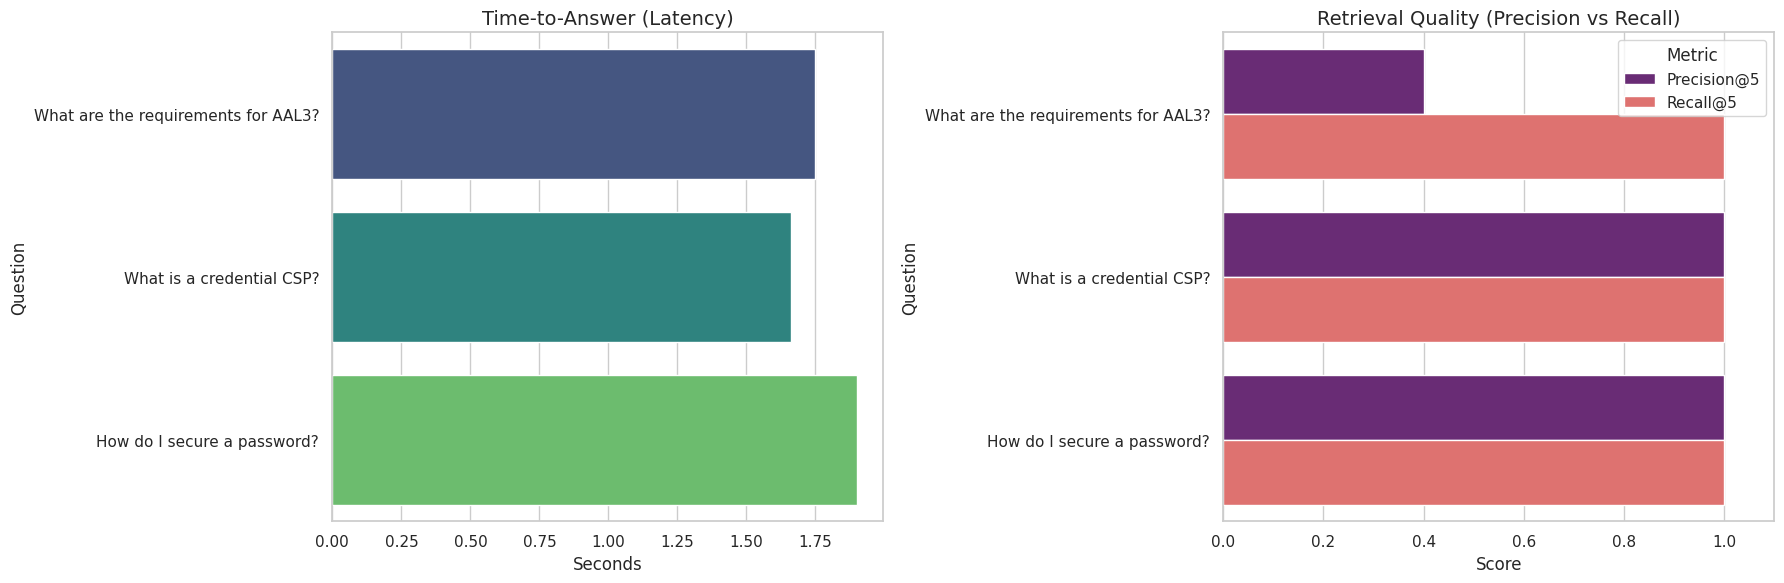

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Latency per Question
sns.barplot(data=df_results, x="Latency (s)", y="Question", ax=axes[0], palette="viridis")
axes[0].set_title("Time-to-Answer (Latency)", fontsize=14)
axes[0].set_xlabel("Seconds")

# Plot 2: Precision vs Recall
# Melt the dataframe to make it suitable for a grouped bar chart
df_melted = df_results.melt(id_vars="Question", value_vars=["Precision@5", "Recall@5"], var_name="Metric", value_name="Score")
sns.barplot(data=df_melted, x="Score", y="Question", hue="Metric", ax=axes[1], palette="magma")
axes[1].set_title("Retrieval Quality (Precision vs Recall)", fontsize=14)
axes[1].set_xlim(0, 1.1)  # Scores are between 0 and 1

plt.tight_layout()
plt.show()